<span style="font-weight: bold; font-size: 2em">Topic Modeling Of Attractions</span>

主要通过文本挖掘的方法得出可供用户选择的标签。首先，通过*LDA主题模型*提取各景点的分主题及其主题词；然后，通过*K-means聚类方法*根据主题词将分主题聚为六类，并通过总结每个类别的景点特点确定景点的标签。

# 景点的主题划分——*LDA模型*

*LDA*是一种文档主题生成模型，也是一种非监督的机器学习技术，常称为一个三层贝叶斯概率模型，包含词、主题和文档三层结构。它认为一篇文章的每个词都是通过“以一定概率选择了某个主题，并从这个主题中以一定概率选择某个词语”这样一个过程得到，其中文档到主题服从多项式分布，主题到词服从多项式分布。

选择LDA模型的原因包括：
- 自动化的主题发现： *LDA*能够自动从数据中发现主题，这对于没有具体某些景点主题标签的先验知识的情况下非常有用。
- 处理未标注数据： *LDA*不需要标注数据，这意味着可以直接在用户评论文本上应用LDA，而无需进行繁琐的数据标注工作。
- 可解释性： *LDA*的输出（每个文档的主题分布和每个主题的词分布）直观且易于解释。这可以帮助确定每个景点的标签，并对旅游路线进行分类。
- 灵活性： *LDA*模型的参数可以根据实际需求调整，例如调整主题数量以获取更精细或更广泛的主题分类。

In [1]:
from gensim import corpora, models
import pandas as pd
from tabulate import tabulate
import os

os.environ['OMP_NUM_THREADS'] = '1'

def extract_topics(comments):
    texts = comments.splitlines()

    # 将每条评论分词后的结果作为一个文档
    documents = [text.split() for text in texts]

    # 创建字典
    dictionary = corpora.Dictionary(documents)

    # 创建语料库
    corpus = [dictionary.doc2bow(document) for document in documents]

    # 应用LDA模型
    lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, passes=20, iterations=300, 
                          alpha='auto', eta='auto', random_state=0)

    # 得到每个主题的关键词
    topics = lda.print_topics(num_words=10)

    return topics
    

def display_df_data(df, num_rows=5, show_index=False):
    """
    Display the first few rows of data in the dataframe.

    Parameters:
        df (dataframe): The dataframe which contains the data.
        num_rows (int): The number of rows to display initially. Default is 7.
        show_index: Whether show index or not.
    """
    if len(df) > num_rows:
        df = df.head(num_rows)
        
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=show_index))

## 基于各景点的中文分词，运用*LDA模型*，提取各景区的主题和关键词。
为了提高*LDA模型*的准确率，我通过调整几个关键参数优化了模型性能：
- *num_topics*: 主题数量，这是*LDA模型*最重要的参数之一。一开始设想是提取各景区的三个主题和十个关键词。但是通过逐一分析各景点的主题词提取结果，发现有些不是很符合。因此尝试修改逐个景点的主题数，但不修改主题词数目，得到更符合实际的各景点分主题。
- *passes*: 整个语料库的遍历次数。更多的遍历次数可以增加模型的稳定性和准确性，但同时也增加了训练的时间。
- *iterations*: 每次遍历语料库时，每个文档的最大迭代次数。增加迭代次数提高了模型质量，但也会导致更长的训练时间。
- *alpha*和*eta*: 这两个参数是与主题先验相关的超参数。设置为*'auto'*，表示由模型自动学习最优值
- *random_state = 0*: 为了确保结果的可重现性。

In [2]:
comment_processed_file_path = '../data/processed/attractions_reviews.xlsx'

df_comment = pd.read_excel(comment_processed_file_path)

# 使用列表收集数据
data = []

for index, row in df_comment.iterrows():
    comment = row['comment']
    
    topics = extract_topics(comment)
    
    # 将主题关键词作为字符串存储
    topic_keywords = [' '.join(topic[1].split('"')[1::2]) for topic in topics]  # 提取关键词，去除数字
    data.append({'Topic 1': topic_keywords[0], 'Topic 2': topic_keywords[1]})


# 在循环结束后从列表创建DataFrame
temp_df = pd.DataFrame(data)
df_comment[['Topic 1', 'Topic 2']] = temp_df[['Topic 1', 'Topic 2']]

df_comment.to_excel(comment_processed_file_path, index=False)

其中 *大三巴牌坊* 的主题划分结果如下：

In [3]:
display_df_data(df_comment[df_comment['Attraction'] == '大三巴牌坊'][['Topic 1', 'Topic 2']])

+-----------------------------------------------------+---------------------------------------------------+
| Topic 1                                             | Topic 2                                           |
|-----------------------------------------------------+---------------------------------------------------|
| 建筑 打卡 景点 地标 历史 教堂 标志性 值得 不错 牌坊 | 教堂 建筑 历史 景点 炮台 牌坊 游客 地标 打卡 大火 |
+-----------------------------------------------------+---------------------------------------------------+


# 主题词的提取——*K-Means文本聚类*
*K-Means*是一种广泛使用的聚类算法，它通过迭代计算来将数据分成若干个类（K个类）。使用*K-Means文本聚类*进行主题词的提取是一个在文本数据分析中常见的方法，它能帮助我们从大量文本中识别出共性和差异，进而将文本数据聚类到不同的群组中。

## 加载和准备数据
首先，我们需要加载Excel文件中的数据，然后生成词频权重矩阵。

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

df_topic = pd.read_excel(comment_processed_file_path)

# 合并两个主题列为一个文本字段
df_topic['Topic'] = df_topic['Topic 1'] + ' ' + df_topic['Topic 2']

# 使用TF-IDF向量化器转换文本数据
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_topic['Topic'])

## 应用K-means聚类
接下来，我们将应用K-means算法对主题词进行聚类。我们需要选择一个合适的类数（即`n_clusters`），这可以通过尝试不同的值或使用诸如肘部方法来确定。

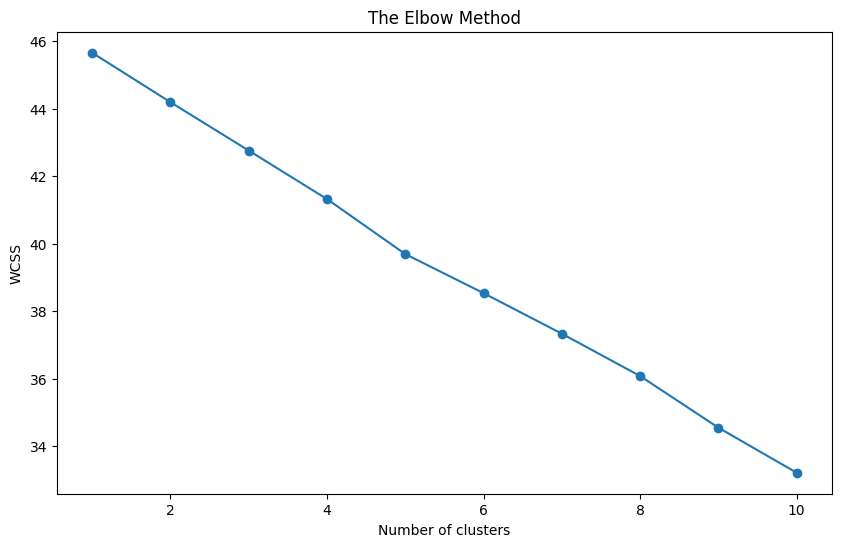

In [5]:
from sklearn.cluster import KMeans

# 尝试不同的聚类数并计算每个聚类数的WCSS
wcss = []
for i in range(1, 11):  # 测试1到10个聚类
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=8, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # inertia_ 是KMeans算法的属性，表示WCSS

# 绘制肘部图
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [6]:
# 肘部图不能得到明显的结果，于是通过测试选择聚类的数目为8
num_clusters = 8

# 应用K-means算法
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, random_state=0)
clusters = kmeans.fit_predict(X)

# 将聚类结果添加到原始数据框中
df_topic['Cluster'] = clusters

## 微调和命名聚类
根据实际情况对聚类结果进行微调，先通过查看每个聚类的景点和关键词来检查聚类结果（各聚类下前5个景点）。

In [7]:
# 查看每个聚类中的景点和关键词并储存
for i in range(num_clusters):
    print(f'Cluster {i}:')
    display_df_data(df_topic[df_topic['Cluster'] == i][['Attraction', 'Topic']])
    
df_topic.drop(columns=['Cluster'], inplace=True)
df_topic.to_excel(comment_processed_file_path, index=False)

Cluster 0:
+--------------+---------------------------------------------------------------------------------------------------------+
| Attraction   | Topic                                                                                                   |
|--------------+---------------------------------------------------------------------------------------------------------|
| 东望洋山     | 灯塔 松山 炮台 公园 坐标 远东 古老 历史 山 俯瞰 山 灯塔 松山 山上 炮台 教堂 景色 坐 缆车 跑步           |
| 二龙喉公园   | 公园 缆车 景色 坐 水池 松山 真的 拜斯 动物 百多年 公园 缆车 特别 不错 坐 值得 交通 环境 松山 动物       |
| 亚婆井前地   | 建筑 山泉 水池 历史 葡萄牙 大屋 广场 最早 值得 居民 历史 水池 建筑 山泉 大屋 文化遗产 世界 走 休息 景点 |
+--------------+---------------------------------------------------------------------------------------------------------+
Cluster 1:
+------------------+---------------------------------------------------------------------------------------------------------------+
| Attraction       | Topic                                                                                          

然后把自己思路告诉ChatGPT 4，让它再做一遍。最终它确定聚为八类符合客观实际（一致），并给出了参考的景点标签。
接下来我结合自己生成的和ChatGPT4给出的结果，通过人为微调进一步地确定景点标签，并命名为*Park、Square、Street、Museum、Performance、Western-Church、Chinese、Landmark*。部分聚类结果展示如下（各标签下前5个景点，顺序随机）：

In [8]:
topic_cluster_folder_path = '../data/processed/attractions_topic_clustering'

files = [f for f in os.listdir(topic_cluster_folder_path) if f.endswith('.xlsx')]

for file in files:
    file_path = os.path.join(topic_cluster_folder_path, file)
    df_cluster = pd.read_excel(file_path)
    
    df_cluster = pd.merge(df_cluster[['Attraction']], df_topic, on='Attraction', how='left')
    
    print(f"The attractions under the '{file[:-5]}' tag")
    display_df_data(df_cluster[['Attraction', 'Topic']])
    
    df_cluster.to_excel(file_path, index=False)

The attractions under the 'Chinese' tag
+------------------+---------------------------------------------------------------------------------------------------------------+
| Attraction       | Topic                                                                                                         |
|------------------+---------------------------------------------------------------------------------------------------------------|
| 下环街市熟食中心 | 吃 美食 街市 好吃 中心 熟食 味道 推荐 红豆饼 本地人 吃 街市 美食 好吃 熟食 味道 中心 推荐 本地人 市场         |
| 卢家大屋         | 大屋 建筑 中式 大宅 典型 参观 卢华绍 商人 建筑风格 历史 大屋 卢九 大堂 精美 文化局 修复 管理 商人 巷 金玉     |
| 卢廉若公园       | 公园 风格 苏州园林 池塘 园林 建筑 假山 特色 感觉 景色 公园 花园 很小 不错 荷花 开放 亭台楼阁 苏州园林 美 夏天 |
| 妈阁庙           | 阁 香火 历史 庙 景点 庙宇 文化 建筑 著名 供奉 香火 景点 历史 阁 不错 庙宇 游客 旺盛 特别 古老                 |
| 普济禅院         | 条约 禅院 历史 望厦 寺庙 花园 值得 庙宇 签订 美 禅院 历史 条约 供奉 寺庙 庙宇 值得 望厦 特别 佛教             |
+------------------+---------------------------------------------------------------------------------------------------------